# **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона

## 1. Подготовка исходных данных

- `service_types` -- таблица типов сервисов.
- `blocks` -- слой городских кварталов с разной информацией.
- `acc_mx` -- матрица доступности городских кварталов.

In [74]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types_df = pd.read_pickle('./data/service_types.pickle')
blocks_gdf = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [75]:
blocks_gdf['population'] = blocks_gdf['population'].fillna(0)

### 1.1. Создание колонок

Чтобы не мучаться с передачей всего добра в методы и сразу скушать что надо, можем суммировать нужные колонки по `blocksnet` параметру.

Тогда из наших столбцов получим новые столбцы:
- `count_1` -> `count_park`
- `capacity_1` -> `capacity_park`
- ...
- `count_x` + `count_y` -> `count_z`
- ...

In [76]:
def generate_blocksnet_columns(blocks_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame) -> gpd.GeoDataFrame:
    
    from typing import cast

    st_df = service_types_df[~service_types_df.blocksnet.isna()].copy()
    st_df['service_type_id'] = st_df.index
    agg_df = st_df.groupby('blocksnet').agg({'service_type_id': lambda s : list(s)})
    new_columns = {}
    for st_name, row in agg_df.iterrows():
        st_ids = row['service_type_id']
        for prefix in ['count', 'capacity']:
            sum_df = blocks_gdf[[f'{prefix}_{st_id}' for st_id in st_ids]].sum(axis=1)
            new_columns[f'{prefix}_{st_name}'] = sum_df
    new_columns_df = pd.DataFrame.from_dict(new_columns)
    
    df = pd.concat([blocks_gdf, new_columns_df], axis=1)
    return cast(gpd.GeoDataFrame, df)

blocks_gdf = generate_blocksnet_columns(blocks_gdf, service_types_df)

### 1.2. Подготовка списка сервисов

Нужны только те списки сервисов, у которых есть `infrastructure_type` и у которых известно имя `blocksnet`

In [77]:
service_types_df = service_types_df[~service_types_df['infrastructure_type'].isna()].copy()
service_types_df = service_types_df[~service_types_df['blocksnet'].isna()].copy()
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,"[8, 18, 1]",park
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[2, 4, 1]",school
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university


## 2A. Эффекты ДО

Если `scenario_id` является `base_scenario`, то мы не обязаны ничего оптимизировать и просто должны посчитать обеспеченность as is.

In [79]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_accessibility_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
  return list(context_blocks.index)

In [80]:
from blocksnet.analysis.provision import competitive_provision
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> gpd.GeoDataFrame:
  _, demand, accessibility = service_types_config[service_type].values()
  context_ids = _get_accessibility_context(blocks, acc_mx, accessibility)
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    blocks_df = blocks[['geometry','population']].fillna(0)
    blocks_df['capacity'] = 0
  else:
    blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  return blocks[['geometry']].join(prov_df, how='right')

### Получаем слои с оценкой обеспеченности

In [81]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types_df.index:
    st_name = service_types_df.loc[st_id,'blocksnet']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks_gdf, acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

Например:

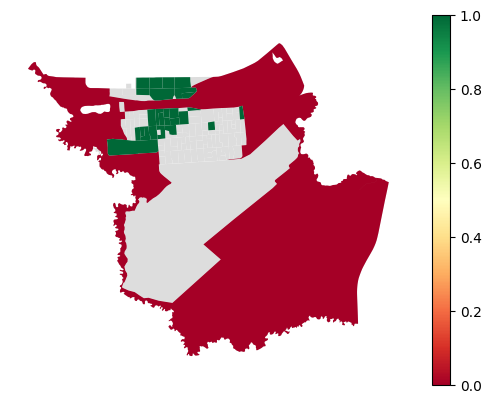

In [82]:
ax = prov_gdfs['park'].plot(color='#ddd')
prov_gdfs['park'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

### Получаем общие оценки обеспеченности

In [83]:
from blocksnet.analysis.provision import provision_strong_total

prov_totals_before = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_before[st_name] = total

В итоге:

In [84]:
prov_totals_before

{'park': 0.9904610492845787,
 'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.0,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 0.0,
 'hospital': 0.0,
 'library': 0.9666666666666667,
 'museum': 0.0,
 'theatre': 1.0,
 'cinema': 0.0,
 'mall': 1.0,
 'stadium': 1.0,
 'cafe': 0.0,
 'restaurant': 0.9411764705882353,
 'bar': 0.0,
 'pitch': 1.0,
 'playground': 0.0,
 'police': 0.0,
 'train_station': 0.15151515151515152,
 'fuel': 1.0,
 'supermarket': 0.0,
 'market': 1.0,
 'post': 1.0,
 'bank': 0.98989898989899,
 'veterinary': 0.0,
 'hotel': 1.0,
 'religion': 0.0,
 'sanatorium': 0.0}

### Результат

В результате имеем следующие данные для ситуации ДО:
- `prov_gdfs : dict[str, gpd.GeoDataFrame]` -- слои с оценкой обеспеченности по выбранным типам сервисов
- `prov_totals : dict[str, float | None]` -- оценки обеспеченности

## 2B. Эффекты ПОСЛЕ

Если `scenario_id` не является `base_scenario`, то для заданного пользователем функционального зонирования мы должны предсказать возможную обеспеченность (по сути, лучший случай).

### Подготовка данных

Для каждого `infrastructure_type` также добавим весовой коэффициент, чтобы отдать предпочтение базовым сервисам, а остальные добавлять по возможности.

In [85]:
INFRASTRUCTURES_WEIGHTS = {
    'basic': 0.5714,
    'additional': 0.2857,
    'comfort': 0.1429
}

service_types_df['infrastructure_weight'] = service_types_df['infrastructure_type'].map(INFRASTRUCTURES_WEIGHTS) * service_types_df['weight']
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet,infrastructure_weight
service_type_id,,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,"[8, 18, 1]",park,0.11428
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach,0.07145
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten,0.11428
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[2, 4, 1]",school,0.11428
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university,0.02858


Готовим словарь, какой квартал в какой ФЗ переводим.

`blocks_lus : dict[int, LandUse]`

In [86]:
from blocksnet.enums import LandUse

blocks_lus = blocks_gdf.loc[blocks_gdf['is_project'],'land_use']
blocks_lus = blocks_lus[~blocks_lus.isna()]
blocks_lus = blocks_lus.to_dict()
# blocks_lus[0] = LandUse.RESIDENTIAL #FIXME УДАЛИТЬ!!! ЭТО ДЛЯ ПРИМЕРА

Инициализируем экземпляр класса оптимизатора.

In [87]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    GradientChooser,
    AreaSolution
)

var_adapter = AreaSolution(blocks_lus)

facade = Facade(
    blocks_lu=blocks_lus,
    blocks_df=blocks_gdf,
    accessibility_matrix=acc_mx,
    var_adapter=var_adapter,
)


Добавляем информацию о существующих типах сервисов.

**ВАЖНО**: если сервиса нет в слое кварталов, просто добавляем `DataFrame` с нулевыми `capacity` для него. Ведь мы же должны что-то расставлять.

ЛИБО

Можно попробовать на этапе сборки слоя просто добавлять пустой столбец, чтобы не терять.

In [88]:
for st_id, row in service_types_df.iterrows():
    st_name = row['blocksnet']
    st_weight = row['infrastructure_weight']
    st_column = f'capacity_{st_name}'
    df = blocks_gdf.rename(columns={st_column: 'capacity'})[['capacity']].fillna(0)
    facade.add_service_type(st_name, st_weight, df)

### Оптимизация

Запускаем оптимизатор...

In [89]:
MAX_EVALS = 1000 # сколько раз будет считаться обеспеченность. Можно ставить и большее число, если ориентируемся только на время
MAX_RUNS = 1000 # сколько итераций будет считаться в оптимизации. Так же ставим 1000 без проблем
TIMEOUT = 1 * 60 # сколько по времени будет считаться оптимизация (в секундах). Если уже прошло данное время, досчитается итерация и отдаст ответ

In [90]:
services_weights = service_types_df.set_index('blocksnet')['infrastructure_weight'].to_dict()

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=services_weights, max_evals=MAX_EVALS)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=MAX_RUNS, timeout=TIMEOUT, initial_runs_num=1)

[I 2025-10-17 14:00:39,801] A new study created in memory with name: no-name-45432ff9-a99c-4a40-9353-f36ffa808f6d


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-10-17 14:00:39,994] Trial 0 finished with value: 0.22857 and parameters: {'x_0': 0, 'x_1': 12000, 'x_2': 700, 'x_3': 400, 'x_4': 0, 'x_5': 9100}. Best is trial 0 with value: 0.22857.
[I 2025-10-17 14:00:40,069] Trial 1 finished with value: 0.22857 and parameters: {'x_0': 4, 'x_1': 12019, 'x_2': 700, 'x_3': 400, 'x_4': 4113, 'x_5': 9102}. Best is trial 0 with value: 0.22857.
[I 2025-10-17 14:00:40,180] Trial 2 finished with value: 0.17630697368421053 and parameters: {'x_0': 464, 'x_1': 4286, 'x_2': 23, 'x_3': 400, 'x_4': 0, 'x_5': 0}. Best is trial 0 with value: 0.22857.
[I 2025-10-17 14:00:40,367] Trial 3 finished with value: 0.22857 and parameters: {'x_0': 3, 'x_1': 17441, 'x_2': 729, 'x_3': 400, 'x_4': 3766595, 'x_5': 9464}. Best is trial 0 with value: 0.22857.
[I 2025-10-17 14:00:40,492] Trial 4 finished with value: 0.19999 and parameters: {'x_0': 0, 'x_1': 10118, 'x_2': 387, 'x_3': 0, 'x_4': 0, 'x_5': 4941}. Best is trial 0 with value: 0.22857.
[I 2025-10-17 14:00:40,643] T

### Результат

Во-первых, обнуляем для территории все `capacity_`, `count_` и `population`, чтобы Ф22 был адекватен

In [101]:
columns = [c for c in blocks_gdf.columns if 'capacity_' in c or 'count_' in c or 'population' in c]
blocks_gdf.loc[blocks_gdf.is_project, columns] = 0

Обновляем параметры кварталов согласно тому, что наоптимизировали

In [102]:
def get_solution_df(solution):
    units_df = facade.solution_to_services_df(solution)
    population_df = facade.get_solution_area_df(solution).loc[list(facade._blocks_lu.keys())]

    df = (
        units_df
        .groupby(['block_id', 'service_type'])
        .agg({'capacity': 'sum', 'count': 'sum'})
        .unstack('service_type')  # превращаем service_type в столбцы
    )
    columns = []

    for col in df.columns:
        name = col[0]
        st_name = col[1]
        column = f'{name}_{st_name}'
        columns.append(column)
    df.columns = columns

    df.loc[population_df.index, 'population'] = population_df['population']

    return df.fillna(0)

solution_df = get_solution_df(best_x)
blocks_gdf.loc[solution_df.index, solution_df.columns] += solution_df

- Если для данного данного сервиса нет в списке доступных для данного `land_use`, он не оптимизируется и не учитывается.
- То что не оптимизировали, надо пересчитать, особенно если прибавилось население. Добавляем это население по возможности

In [103]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

prov_gdfs = {}

for st_name in prov_totals_before.keys():
    if st_name in facade._chosen_service_types:
        prov_df = facade._provision_adapter.get_last_provision_df(st_name)
        prov_gdf = blocks_gdf[['geometry']].join(prov_df, how='right')
        prov_gdfs[st_name] = prov_gdf
    else:
        column = f'capacity_{st_name}'
        _,demand,accessibility = service_types_config[st_name].values()
        df = blocks_gdf.copy()
        prov_gdf = _assess_provision(df, acc_mx, st_name)
        prov_gdfs[st_name] = prov_gdf

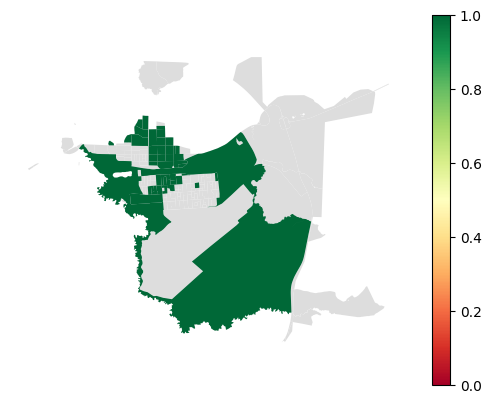

In [104]:
ax = prov_gdfs['hospital'].plot(color='#ddd')
prov_gdfs['hospital'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

Чиселки обеспеченности для графика

In [105]:
prov_totals_after = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_after[st_name] = total

Если какой-то сервис тут отсутствует, можно брать с `base_scenario` (?? я подумаю еще правильно ли это)

In [106]:
prov_totals_after

{'park': 0.9904610492845787,
 'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.0,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 0.0,
 'hospital': 1.0,
 'library': 0.9666666666666667,
 'museum': 0.0,
 'theatre': 1.0,
 'cinema': 0.0,
 'mall': 1.0,
 'stadium': 1.0,
 'cafe': 0.0,
 'restaurant': 0.9411764705882353,
 'bar': 0.0,
 'pitch': 1.0,
 'playground': 0.0,
 'police': 0.0,
 'train_station': 0.15151515151515152,
 'fuel': 1.0,
 'supermarket': 0.0,
 'market': 1.0,
 'post': 1.0,
 'bank': 0.98989898989899,
 'veterinary': 0.0,
 'hotel': 1.0,
 'religion': 1.0,
 'sanatorium': 0.0}

<Axes: >

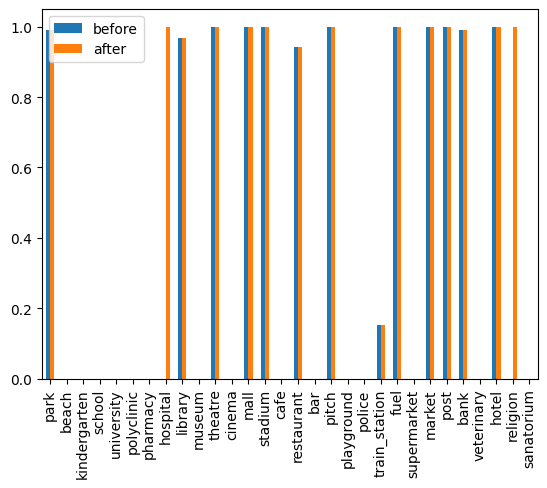

In [107]:
provisions_df = pd.DataFrame.from_dict({'before': prov_totals_before, 'after': prov_totals_after})
provisions_df.plot.bar()

## Выход в другие модули

Чтоб могли посчитать и сопоставить

In [108]:
blocks_gdf.to_pickle('./data/blocks_f35.pickle')

# **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.

Берем результат из пункта `2.b` и разворачиваем его на кварталы: куда что ставить:

- `block_id` -- номер квартала, куда ставим.
- `service_type` -- тип сервиса.
- `site_area` -- занимаемая площадь квартала.
- `build_floor_area` -- занимаемая площадь зданий.
- `capacity` -- суммарная емкость типа застройки
- `count` -- количество расставляемых объектов данного типа в данном квартале

In [109]:
units_df = facade.solution_to_services_df(best_x)
units_df

,block_id,service_type,site_area,build_floor_area,capacity,count
4,0,polyclinic,0.0,400.0,50,1
6,0,hospital,3500.0,660.0,110,3
10,0,police,700.0,240.0,60,1
13,0,fuel,400.0,40.0,30,1
16,0,post,0.0,200.0,60,1
19,0,religion,9100.0,2000.0,1300,1


Отсюда нужно взять `population` для каждого квартала (`index` здесь это тот же индекс из `blocks : pd.DataFrame`)

In [110]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

,population,build_floor_area,living_area,footprint_area
0,0.0,9.499725e+05,0,189994.501474
1,0.0,6.405045e+07,0,0.000000
2,0.0,2.194551e+08,0,0.000000
3,0.0,3.320482e+08,0,0.000000
4,0.0,6.468579e+05,0,0.000000
...,...,...,...,...
456,0.0,1.288098e+04,0,0.000000
457,0.0,8.803568e+02,0,0.000000
458,0.0,5.518729e+02,0,0.000000
459,0.0,7.127272e+02,0,0.000000
